# 1d3v electron hybrid code for R/L-waves with stationary ions

## 1. The model
The electron hybrid model for cold electrons with linearized fluid equations and hot kinetic electrons (Vlasov equation) reads

\begin{align}
&\frac{\partial\tilde{\mathbf{j}}_\mathrm{c}}{\partial t}=\epsilon_0\Omega_\mathrm{pe}^2\tilde{\mathbf{E}}+\tilde{\mathbf{j}}_\mathrm{c}\times\mathbf{\Omega}_\mathrm{ce},\\
&\frac{\partial f_\mathrm{h}}{\partial t}+\mathbf{v}\cdot\nabla f_\mathrm{h}+\frac{q_\mathrm{e}}{m_\mathrm{e}}(\mathbf{E}+\mathbf{v}\times\mathbf{B})\cdot\nabla_\mathbf{v}f_\mathrm{h}=0,\\
&\frac{\partial \tilde{\mathbf{B}}}{\partial t}=-\nabla\times\tilde{\mathbf{E}},\\
&\frac{1}{c^2}\frac{\partial \tilde{\mathbf{E}}}{\partial t}=\nabla\times\tilde{\mathbf{B}}-\mu_0\tilde{\mathbf{j}}_\mathrm{c}-\mu_0q_\mathrm{e}\int\mathbf{v}\tilde{f}_\mathrm{h}\,\mathrm{d}^3\mathbf{v},
\end{align}

where $\mathbf{\Omega}_\mathrm{ce}=q_\mathrm{e}\mathbf{B}_0/m_\mathrm{e}$ is the oriented electron cyclotron frequency corresponding to the background field $\mathbf{B}_0$ and $\Omega_{\mathrm{pe}}^2=n_{\mathrm{c}0}e^2/\epsilon_0m_\mathrm{e}$ the plasma frequency of the cold electrons. Here, only wave propagation parallel to the background magnetic field $\textbf{B}_0=B_0\textbf{e}_z$ is considered, i.e. $\textbf{k}=k\textbf{e}_z$. Therefore the nabla operator is simply $\nabla=\textbf{e}_z\partial_z$.

## 2. Dispersion relation
Linear theory of the above model leads to the following general dispersion relation for transverse electromagnetic waves and for an arbitrary equilibrium distribution function $f_\mathrm{h}^0(v_\parallel,v_\perp)=n_{\mathrm{h}0}F_\mathrm{h}^0(v_\parallel,v_\perp)$:


\begin{align}
D_{\text{R/L}}(k,\omega)=1-\frac{c^2k^2}{\omega^2}-\frac{\Omega_{\text{pe}}^2}{\omega(\omega\pm\Omega_{\text{ce}})}+\nu_\text{h}\frac{\Omega_{\text{pe}}^2}{\omega}\int\frac{v_\perp}{2}\frac{\hat{G}F_\text{h}^0}{\omega\pm\Omega_{\text{ce}}-kv_\parallel}\text{d}^3\textbf{v}=0.
\end{align}

Here $\nu_\text{h}=n_{\text{h}0}/n_{\text{c}0}\ll1$ is the ratio between the hot and cold electron number densities, respectively, $\text{d}^3\textbf{v}=\text{d}v_\parallel\text{d}v_\bot v_\bot 2\pi$ and the differential operator

\begin{align}
\hat{G}=\frac{\partial}{\partial v_\bot}+\frac{k}{\omega}\left(v_\bot\frac{\partial}{\partial v_\parallel}-v_\parallel\frac{\partial}{\partial v_\bot}\right).
\end{align}

For an anisotropic Maxwellian 

\begin{align}
F^0(v_\parallel,v_\bot) = \frac{1}{(2\pi)^{3/2}w_\parallel w_\bot^2}\exp\left(-\frac{v_\parallel^2}{2w_\parallel^2}-\frac{v_\bot^2}{2w_\bot^2}\right)
\end{align}

the dispersion relation is given by

\begin{align}
D_{\text{R/L}}(k,\omega)=1-\frac{c^2k^2}{\omega^2}-\frac{\Omega_{\text{pe}}^2}{\omega(\omega\pm\Omega_{\text{ce}})}+\nu_\text{h}\frac{\Omega_{\text{pe}}^2}{\omega^2}\left[\frac{\omega}{k\sqrt{2}w_\parallel}Z(\xi^{\pm})-\left(1-\frac{w_\bot^2}{w_\parallel^2}\right)(1+\xi^{\pm} Z(\xi^{\pm}))\right]=0, 
\end{align}

where $\xi^\pm=(\omega\pm\Omega_\mathrm{ce})/k\sqrt{2}w_{\parallel}$ and $Z$ is the plasma dispersion function given by 

\begin{align}
Z(\xi)=\sqrt{\pi}\mathrm{e}^{-\xi^2}\left(i-\frac{2}{\sqrt{\pi}}\int_0^\xi\mathrm{e}^{t^2}\mathrm{d}t\right)=\sqrt{\pi}\mathrm{e}^{-\xi^2}(i-\mathrm{erfi}(\xi)).
\end{align}

## 3. Discretization
As a first step, we write the momentum balance equation, Faraday's law and Amp\'{e}res law in the compact form

\begin{align}
\begin{cases}
\displaystyle\frac{\partial\mathbf{U}}{\partial t}+A_1\frac{\partial\mathbf{U}}{\partial z}+A_2\mathbf{U}=\mathbf{S},\\
\displaystyle\mathbf{U}(0,t)=\mathbf{U}(L,t),\quad\mathbf{U}(z,t=0)=\mathbf{U}_0(z)
\end{cases}
\end{align}
\end{subequations}
for the vector of unknowns $\mathbf{U}=(\tilde{E}_x,\tilde{E}_y,\tilde{B}_x,\tilde{B}_y,\tilde{j}_{\mathrm{c}x},\tilde{j}_{\mathrm{c}y})$ with initial condition $\mathbf{U}_0$ and impose periodic boundary conditions on the domain $\Omega=(0,L)$, where $L$ is the length of the computational domain. The constant matrices $A_1,A_2\in\mathbb{R}^{6\times6}$ and the source term $\mathbf{S}$ are
\begin{align}
A_1&=
\begin{pmatrix}
0 &0  &0 &c^2  &0 &0 \\
0 &0  &-c^2 &0 &0 &0 \\
0 &-1  &0 &0 &0 &0  \\
1 &0  &0 &0 &0 &0  \\
0 &0  &0 &0 &0 &0   \\
0 &0  &0 &0 &0 &0 
\end{pmatrix},
\end{align}
\begin{align}
A_2&=
\begin{pmatrix}
0 &0 &0 &0 &\mu_0c^2 &0 \\
0 &0 &0 &0 &0 &\mu_0c^2 \\
0 &0 &0 &0 &0 &0 \\
0 &0 &0 &0 &0 &0 \\
-\epsilon_0\Omega_{\mathrm{pe}}^2 &0 &0 &0 &0 &-\Omega_{\mathrm{ce}} \\
0 &-\epsilon_0\Omega_{\mathrm{pe}}^2 &0 &0 &\Omega_{\mathrm{ce}} &0 \\
\end{pmatrix},
\end{align}
\begin{align}
\textbf{S}&=
\begin{pmatrix}
-\mu_0c^2 j_{\mathrm{h}x} \\
-\mu_0c^2 j_{\mathrm{h}y} \\
0 \\
0 \\
0 \\
0
\end{pmatrix}.
\end{align}

Using B-spline finite elements yields the semi-discrete system:

\begin{align}
\mathbb{M}_\mathrm{b}\frac{\mathrm{d}\mathbf{u}}{\mathrm{d}t}=-\tilde{\mathbb{C}}\mathbf{u}-\tilde{\mathbb{M}}\mathbf{u}+\mathbb{S}
\end{align}

for the time evolution of all finite element coefficients $\mathbf{u}\in\mathbb{R}^{6N}$. We introduced the block matrices $\mathbb{M}_\mathrm{b}:=\mathbb{M}\otimes I_6\in\mathbb{R}^{6N\times 6N}$, $\tilde{\mathbb{C}}:=\mathbb{C}\otimes A_1\in\mathbb{R}^{6N\times 6N}$ and $\tilde{\mathbb{M}}:=\mathbb{M}\otimes A_2\in\mathbb{R}^{6N\times 6N}$. $\mathbb{M}$ and $\mathbb{C}$ are the mass and advection matrix with entries

\begin{align}
m_{ij}=\int\varphi_i\varphi_j\,\text{d}z, \\
c_{ij}=\int\varphi_i\varphi_j^\prime\,\text{d}z
\end{align}

respectively. The vector $\mathbb{S}$ is given by
\begin{align}
&\mathbb{S}:=\begin{pmatrix}
\int_0^L\mathbf{S}\varphi_0(z)\text{d}z \\
\vdots \\
\int_0^L\mathbf{S}\varphi_{N-1}(z)\text{d}z
\end{pmatrix}\quad\in\mathbb{R}^{6N}.
\end{align}

Having done the spatial discretization, the next step is to apply a time stepping scheme on the semi-discrete system. Here, we use a second-order Crank-Nicolson scheme which consists of applying a mid-point rule on the quantities on the right-hand side. Denoting the time step by $n$, i.e. $t_n=n\Delta t$, the fully discrete matrix formulation for advancing $\mathbf{u}^n\rightarrow\mathbf{u}^{n+1}$ then reads
\begin{align}
\left(\mathbb{M}_\mathrm{b}+\frac{1}{2}\Delta t\tilde{\mathbb{C}}+\frac{1}{2}\Delta t\tilde{\mathbb{M}}\right)\mathbf{u}^{n+1}=\left(\mathbb{M}_\mathrm{b}-\frac{1}{2}\Delta t\tilde{\mathbb{C}}-\frac{1}{2}\Delta t\tilde{\mathbb{M}}\right)\mathbf{u}^n+\frac{1}{2}\Delta t\left(\mathbb{S}^{n+1}+\mathbb{S}^n\right).
\end{align}

Finally, we use a classical PIC solver to treat the source term and thus approximate the distribution function $f_\mathrm{h}$ by a sum of Dirac masses in the four-dimensional phase space
\begin{align}
f_\mathrm{h}(z,\mathbf{v},t)\approx\sum_{k=1}^{N_\mathrm{p}}w_k\delta(z-z_k(t))\delta(\mathbf{v}-\mathbf{v}_k(t)),
\end{align}
where $N_\mathrm{p}$ is the number of particles, $w_k$ is the weight of the $k$-th particle and $\mathbf{v}_k=\mathbf{v}_k(t)$ and $z_k=z_k(t)$ are the particles' velocities and positions, respectively, satisfying the equations of motion


\begin{alignat}{2}
&\frac{\mathrm{d}\mathbf{v}_k}{\mathrm{d}t}=\frac{q_\mathrm{e}}{m_\mathrm{e}}\left[\mathbf{E}(z_k(t),t)+\mathbf{v}_k(t)\times\mathbf{B}(z_k(t),t)\right],\quad\quad &\mathbf{v}_k(0)=\mathbf{v}_k^0,\\
&\frac{\mathrm{d}z_k}{\mathrm{d}t}=v_{kz}, &z_k(0)=z_k^0.
\end{alignat}

We solve this set of ordinary differential equations in time with the classical Boris method which uses a staggered grid for positions and velocities, i.e. positions are computed at integer time steps ($z_k^n \rightarrow z_k^{n+1}$), whereas velocities are computed at interleaved time steps ($\mathbf{v}_k^{n-1/2}\rightarrow\mathbf{v}_k^{n+1/2}$).


The meaning of the particles' weights $w_k$ becomes clear if one uses a Monte Carlo interpretation for the evaluation of the integrals over the current contribution from the energetic electrons appearing in the semi-discrete system:

\begin{align}
\int_0^Lj_{\mathrm{h}x/y}\varphi_j\mathrm{d}z=q_\mathrm{e}\int_0^L\int\underbrace{v_{x/y}\frac{f_\mathrm{h}}{g_\mathrm{h}}\varphi_j}_{=:\mathcal{R}}g_\mathrm{h}\mathrm{d}^3\mathbf{v}\mathrm{d}z\approx q_\mathrm{e}\frac{1}{N_\mathrm{p}}\sum_{k=1}^{N_\mathrm{p}}v_{kx/y}(t)\frac{f_\mathrm{h}^0(z_k^0,\mathbf{v}_k^0)}{g_\mathrm{h}^0(z_k^0,\mathbf{v}_k^0)}\varphi_j(z_k(t))
\end{align}

The last expression is an estimator of the expectation value of the random variable $\mathcal{R}:=v_{x/y}\varphi_jf_\mathrm{h}/g_\mathrm{h}$ distributed under the probability density function (PDF) $g_\mathrm{h}$ in phase space. Since $g_\mathrm{h}$ is a PDF it must be normalized to one. Note that we used that the distribution function $f_\mathrm{h}$ and the PDF $g_\mathrm{h}$ are constant along a particle trajectory according to the Vlasov equation, i.e. $f_\mathrm{h}(z_k(t),\mathbf{v}_k(t),t)=f_\mathrm{h}^0(z_k^0,\mathbf{v}_k^0)$. This means that the weights are fully determined from the initial distribution function $f_\mathrm{h}^0$ and the sampling distribution $g_\mathrm{h}^0$ from which the initial particles are drawn. Throughout this work we shall entirely use the sampling distribution 

\begin{align}
g_\mathrm{h}^0(z,v_x,v_y,v_z)=\frac{1}{L}\frac{1}{(2\pi)^{3/2}w_{\parallel}w_{\perp}^2}\exp\left(-\frac{v_x^2+v_y^2}{2w_{\perp}^2}-\frac{v_z^2}{2w_{\parallel}^2}\right).
\end{align}

Consequently, we sample uniformly in real space and normally in every velocity direction using standard random number generators. With this particular choice $w_k=1/N_\mathrm{p}\cdot f_\mathrm{h}^0(z_k^0,\mathbf{v}_k^0)/g_\mathrm{h}^0(z_k^0,\mathbf{v}_k^0)=n_{\mathrm{h}0}L/N_\mathrm{p}$ for the anisotropic Maxwellian. Finally, since the Boris method computes positions at integer time steps and velocities at interleaved time steps, we approximate the entries of the average vector $\Delta t/2\left(\mathbb{S}^{n+1}+\mathbb{S}^n\right)$ appearing on the right-hand side of the fully discrete system due to the Crank-Nicolson discretization in the following manner:
\begin{align}
-\frac{\mu_0c^2q_\mathrm{e}\Delta t}{2}\sum_{k=1}^{N_\mathrm{p}}w_k\left[v_{kx/y}^{n+1}\varphi_j(z_k^{n+1})+v_{kx/y}^{n}\varphi_j(z_k^{n})\right]\approx-\mu_0c^2q_\mathrm{e}\Delta t\sum_{k=1}^{N_\mathrm{p}}w_kv_{kx/y}^{n+1/2}\varphi_j\left[\frac{1}{2}(z_k^{n+1}+z_k^n)\right].
\end{align}

# 1. The code

In [1]:
import numpy as np
import time
from copy import deepcopy
import Utilitis_HybridCode as utils




# ... saving data? (save = 0: no, save = 1: yes). If yes, name directory
save = 0
title = 'data_wpe=2_wpar=0.2_wperp_0.53_nuh=0.06_L=pi_Nel=32_T=200_dt=0.0125_p=1_Np=1e5_CVoff.txt' 
# ...

# ... save only every saving_step-th time step
saving_step = 1
# ...



# ... physical parameters
eps0 = 1.0                         # ... vacuum permittivity
mu0 = 1.0                          # ... vacuum permeability
c = 1.0                            # ... speed of light
qe = -1.0                          # ... electron charge
me = 1.0                           # ... electron mass
B0z = 1.0                          # ... background magnetic field in z-direction
wce = qe*B0z/me                    # ... electron cyclotron frequency
wpe = 2*np.abs(wce)                # ... cold electron plasma frequency
nuh = 0.002                        # ... ratio of cold/hot electron densities (nh/nc)
nh = nuh*wpe**2                    # ... hot electron density
wpar = 0.1*c                       # ... parallel thermal velocity of energetic particles
wperp = 0.1*c                      # ... perpendicular thermal velocity of energetic particles
# ...



# ... parameters for initial conditions
k = 2                              # ... wavenumber of initial wave field perturbations
ini = 6                            # ... initial conditions for wave fields (3 : sin-perturbation of Bx, 5 : all random, 6 : all zero)
amp = 1e-4                         # ... amplitude of initial wave field perturbations
eps = 0.0                          # ... amplitude of spatial pertubation of distribution function 
# ...



# ... numerical parameters
Lz = 80                            # ... length of z-domain
Nz = 256                           # ... number of elements z-direction
T = 300.0                          # ... simulation time
dt = 0.05                          # ... time step
p = 3                              # ... degree of B-spline basis
Np = np.int(5e4)                   # ... number of energetic simulation particles 
control = 1                        # ... switch on (1) or off control variate (0)
time_integr = 1                    # ... do time integration (1 : yes, 0: no)
# ...



# ... create parameter list
pa = np.zeros(8*Nz + 5)

pa[0]  = eps0
pa[1]  = mu0
pa[2]  = c
pa[3]  = qe 
pa[4]  = me 
pa[5]  = B0z 
pa[6]  = wce 
pa[7]  = wpe 
pa[8]  = nuh 
pa[9]  = nh 
pa[10] = wpar 
pa[11] = wperp 
pa[12] = k 
pa[13] = ini 
pa[14] = amp 
pa[15] = eps 
pa[16] = Lz 
pa[17] = Nz 
pa[18] = T 
pa[19] = dt 
pa[20] = p 
pa[21] = Np
pa[22] = control
pa[23] = saving_step

pa[27] = 1
pa[28] = 1
pa[29] = 0
pa[30] = 0
# ...



# ... discretization parameters
dz = Lz/Nz
zj = np.linspace(0, Lz, Nz + 1)
# ...


# ... some diagnostic values
Eh_eq = Lz*nh*me/2*(wpar**2 + 2*wperp**2)    # ... equilibrium energetic electron energy

en_B  = np.array([])                         # ... magnetic energy
en_E  = np.array([])                         # ... electric energy
en_jc = np.array([])                         # ... cold plasma energy
en_jh = np.array([])                         # ... energetic electron energy
# ...




# ... system matrices for fluid electrons and electromagnetic fields
A10 = np.array([0, 0, 0, +c**2, 0, 0])
A11 = np.array([0, 0, -c**2, 0, 0, 0])
A12 = np.array([0, -1, 0, 0, 0, 0])
A13 = np.array([+1, 0, 0, 0, 0, 0])
A14 = np.array([0, 0, 0, 0, 0, 0])
A15 = np.array([0, 0, 0, 0, 0, 0])
A1 = np.array([A10, A11, A12, A13, A14, A15])

A20 = np.array([0, 0, 0, 0, mu0*c**2, 0])
A21 = np.array([0, 0, 0, 0, 0, mu0*c**2])
A22 = np.array([0, 0, 0, 0, 0, 0])
A23 = np.array([0, 0, 0, 0, 0, 0])
A24 = np.array([-eps0*wpe**2, 0, 0, 0, 0, -wce])
A25 = np.array([0, -eps0*wpe**2, 0, 0, +wce, 0])
A2 = np.array([A20, A21, A22, A23, A24, A25])

s = int(np.sqrt(A1.size))

def B_background_z(z):
    return B0z*(1 + 0*(z - Lz/2)**2)
# ...




# ... time integration 
def update(uj, particles, Ep, Bp ,dt):
    
    
    # ... save old positions
    zold = deepcopy(particles[:, 0])
    # ...
    
    
    # ... update particle velocities from n-1/2 to n+1/2 with fields at time n and positions from n to n+1 with velocities at n+1/2
    znew, vnew = utils.borisPush(particles, dt, Bp, Ep, qe, me, Lz)
    # ...
    
    
    # ... update weights with control variate
    wnew = w0 - control*Maxwell(vnew[:, 0], vnew[:, 1], vnew[:, 2])/g0
    # ...
    
    
    # ... compute hot electron current densities
    jhnew = utils.hotCurrent(vnew[:, 0:2], 1/2*(znew + zold), wnew, zj, bsp, qe, c)
    # ...
     
    
    # ... assemble right-hand side of weak formulation
    Fh[0::s] = -c**2*mu0*jhnew[0::2]
    Fh[1::s] = -c**2*mu0*jhnew[1::2]
    # ...
    
    
    # ... time integration of E,B,jc from n to n+1 with Crank-Nicolson method (use hot current density at n+1/2) 
    ujnew = np.dot(LHSinv,np.dot(RHS, uj) + dt*Fh)
    # ...
    
    
    # ... compute fields at particle positions with new fields 
    Epnew, Bpnew = utils.fieldInterpolation(znew, zj, bsp, ujnew)
    # ...
    
    return znew, vnew, wnew, jhnew, ujnew, Epnew, Bpnew
# ...








# ... initial energetic particle distribution function (perturbed anisotropic Maxwellian)
def fh0(z, vx, vy, vz, eps):
    return (1 + eps*np.cos(k*z))*nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
# ...


# ... Maxwellian for control variate
def Maxwell(vx, vy, vz):
    return nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
# ...


# ... sampling distribution for initial markers
def g_sampling(vx, vy, vz):
    return 1/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))*1/Lz
# ...



# ... create periodic B-spline basis and quadrature grid
bsp, N, quad_points, weights = utils.createBasis(Lz, Nz, p)
# ...



# ... some vectors for linear system
Nb = N - p                        # ... number of unique B-splines for periodic boundary conditions

uj = np.zeros(s*Nb)               # ... coefficients for Galerkin approximation
Fh = np.zeros(s*Nb)               # ... RHS of matrix system

u0 = np.zeros((Nb, s))            # ... L2-projection of initial conditions
# ...





# ... assemble mass and convection matrices
timea = time.time()

M, C = utils.matrixAssembly(bsp, weights, quad_points, B_background_z, 1)[0:2]

timeb = time.time()
print('time for matrix assembly: ' + str(timeb - timea))
# ...





# ... assemble u0
timea = time.time()

for qu in range (0, s):

    def initial(z):
        return utils.IC(z, ini, amp, k, omega = 0)[qu]

    u0[:, qu] = utils.L2proj(bsp, Lz, quad_points, weights, M, initial)

uj = np.reshape(u0, s*Nb)

timeb = time.time()
print('time for initial vector assembly: ' + str(timeb - timea))
# ...




# ... construct block mass and convection matrices
timea = time.time()

M_block = np.kron(M, np.identity(6))
C_tilde = np.kron(C, A1)
M_tilde = np.kron(M, A2)

timeb = time.time()
print('time for block matrix construction: ' + str(timeb - timea))
# ...



# ... create particles (z, vx, vy, vz, wk) and sample positions and velocities according to sampling distribution
particles = np.zeros((Np, 5))
particles[:, 0] = np.random.rand(Np)*Lz
particles[:, 1] = np.random.randn(Np)*wperp
particles[:, 2] = np.random.randn(Np)*wperp
particles[:, 3] = np.random.randn(Np)*wpar
# ...




# ... parameters for control variate
g0 = g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], eps)/g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
# ...



# ... initial fields at particle positions
Ep = np.zeros((Np, 3))
Bp = np.zeros((Np, 3))
Bp[:, 2] = B0z

timea = time.time()

Ep[:, 0:2], Bp[:, 0:2] = utils.fieldInterpolation(particles[:, 0], zj, bsp, uj)

timeb = time.time()
print('time for initial field interpolation: ' + str(timeb - timea))
# ...





# ... initialize velocities by pushing back by -dt/2, compute weights and energy of hot particles
timea = time.time()

particles[:, 1:4] = utils.borisPush(particles, -dt/2, Bp, Ep, qe, me, Lz)[1]
particles[:, 4] = w0 - control*Maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0

timeb = time.time()
print('time for initial particle push: ' + str(timeb - timea))
#





# ... compute matrices for field update
timea = time.time()

LHS = M_block + 1/2*dt*C_tilde + 1/2*dt*M_tilde
RHS = M_block - 1/2*dt*C_tilde - 1/2*dt*M_tilde

LHSinv = np.linalg.inv(LHS)

timeb = time.time()
print('time for update matrix computation: ' + str(timeb - timea))
# ...





# ... create data file and save parameters (first row), initial fields and energies (second row)
if save == 1:
    file = open(title, 'ab')
    np.savetxt(file, np.reshape(pa, (1, 8*Nb + 5)), fmt = '%1.10e')
    data = np.append(uj, np.zeros(2*Nb))


en_E  = np.append(en_E, eps0/2*(np.dot(uj[0::s], np.dot(M, uj[0::s])) + np.dot(uj[1::s], np.dot(M, uj[1::s]))))
en_B  = np.append(en_B, eps0/(2*mu0)*(np.dot(uj[2::s], np.dot(M, uj[2::s])) + np.dot(uj[3::s], np.dot(M, uj[3::s]))))
en_jc = np.append(en_jc, 1/(2*eps0*wpe**2)*(np.dot(uj[4::s], np.dot(M, uj[4::s])) + np.dot(uj[5::s], np.dot(M, uj[5::s]))))
en_jh = np.append(en_jh, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

bx_save = np.append(deepcopy(uj[2::s]), uj[2])

if save == 1:
    data = np.append(data, np.array([en_E[-1], en_B[-1], en_jc[-1], en_jh[-1]]))
    data = np.append(data, 0.)
    np.savetxt(file, np.reshape(data, (1, 8*Nb + 5)), fmt = '%1.10e')
# ...



# ... time integration
if time_integr == 1:

    print('start time integration! (number of time steps : ' + str(int(T/dt)) + ')')
    time_step = 0

    while True:

        try:
            if time_step*dt >= T:
                if save == 1:
                    file.close()
                break

            if time_step%50 == 0:
                print('time steps finished: ' + str(time_step))

            particles[:, 0], particles[:, 1:4], particles[:, 4], jh, uj, Ep[:, 0:2], Bp[:, 0:2] = update(uj, particles, Ep, Bp, dt)

            if time_step%saving_step == 0:

                # ... add data to file
                if save == 1:
                    data = np.append(uj, jh)

                en_E  = np.append(en_E, eps0/2*(np.dot(uj[0::s], np.dot(M, uj[0::s])) + np.dot(uj[1::s], np.dot(M, uj[1::s]))))
                en_B  = np.append(en_B, eps0/(2*mu0)*(np.dot(uj[2::s], np.dot(M, uj[2::s])) + np.dot(uj[3::s], np.dot(M, uj[3::s]))))
                en_jc = np.append(en_jc, 1/(2*eps0*wpe**2)*(np.dot(uj[4::s], np.dot(M, uj[4::s])) + np.dot(uj[5::s], np.dot(M, uj[5::s]))))
                en_jh = np.append(en_jh, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

                bx_save = np.vstack((bx_save, np.append(deepcopy(uj[2::s]), uj[2])))

                if save == 1:
                    data = np.append(data, np.array([en_E[-1], en_B[-1], en_jc[-1], en_jh[-1]]))
                    data = np.append(data, (time_step + 1)*dt)
                    np.savetxt(file, np.reshape(data, (1, 8*Nb + 5)), fmt = '%1.10e')
                # ...

            time_step += 1
        except KeyboardInterrupt:
            print('Pausing...  (Hit ENTER to continue, type quit to exit.)')
            try:
                response = input()
                if response == 'quit':
                    break
                print('Resuming...')
            except KeyboardInterrupt:
                print('Resuming...')
                continue
                
    if save == 1:
        file.close()
# ...

time for matrix assembly: 2.3887264728546143
time for initial vector assembly: 1.078418254852295
time for block matrix construction: 0.10040974617004395
time for initial field interpolation: 0.13074135780334473
time for initial particle push: 0.012695074081420898
time for update matrix computation: 0.4901266098022461
start time integration! (number of time steps : 6000)
time steps finished: 0
time steps finished: 50
time steps finished: 100
time steps finished: 150
time steps finished: 200
time steps finished: 250
time steps finished: 300
time steps finished: 350
time steps finished: 400
time steps finished: 450
time steps finished: 500
time steps finished: 550
time steps finished: 600
time steps finished: 650
time steps finished: 700
time steps finished: 750
time steps finished: 800
time steps finished: 850
time steps finished: 900
time steps finished: 950
time steps finished: 1000
time steps finished: 1050
time steps finished: 1100
time steps finished: 1150
time steps finished: 1200


# 2. Show some results

## 2. 1 Evolution of magnetic field energy

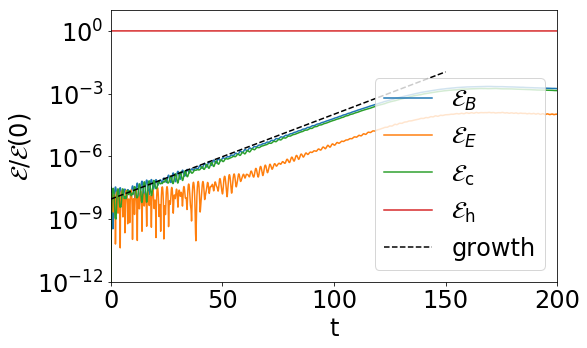

In [31]:
import matplotlib.pyplot as plt

f1 = plt.figure()
f1.set_figheight(5)
f1.set_figwidth(8)

fontsize = 24
#plt.rc('text', usetex = False)
#plt.rc('font', family = 'serif')
plt.rcParams.update({'font.size': fontsize})
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)

Nt = len(en_B) - 1
tn = np.linspace(0, Nt*dt, Nt + 1)
en_tot = en_B + en_E + en_jc + en_jh

plt.semilogy(tn, en_B/en_tot[0], label = r'$\mathcal{E}_{B}$')
plt.semilogy(tn, en_E/en_tot[0], label = r'$\mathcal{E}_{E}$')
plt.semilogy(tn, en_jc/en_tot[0], label = r'$\mathcal{E}_{\mathrm{c}}$')
plt.semilogy(tn, en_jh/en_tot[0], label = r'$\mathcal{E}_{\mathrm{h}}$')
plt.ylim((1e-12, 1e1))
plt.xlim((0, 200))

omega = utils.solveDispersionHybrid(k, +1, c, wce, wpe, wpar, wperp, nuh, 0.5 + 0j, 1e-8)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)

t2 = np.linspace(0, 150, 100) 
plt.semilogy(t2, 9e-9*np.exp(gamma*2*t2), 'k--', label = 'growth')
plt.xlabel('t')
plt.ylabel('$\mathcal{E}/\mathcal{E}(0)$')
plt.legend()

## 2. 2 Evolution of energy conservation error

Text(0.5,1,'Relative error in total energy')

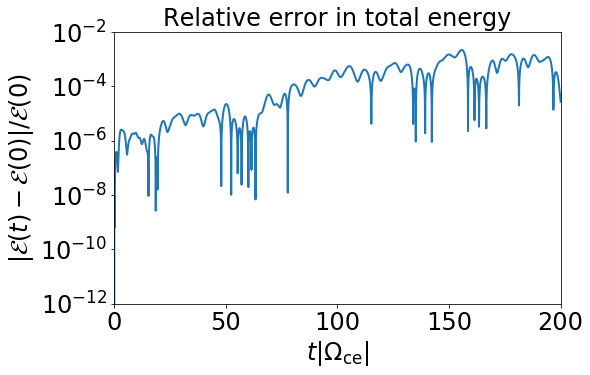

In [14]:
import matplotlib.pyplot as plt

f2 = plt.figure()
f2.set_figheight(5)
f2.set_figwidth(8)

fontsize = 24
#plt.rc('text', usetex = False)
#plt.rc('font', family = 'serif')
plt.rcParams.update({'font.size': fontsize})
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)

Nt = len(en_B) - 1
tn = np.linspace(0, Nt*dt, Nt + 1)
en_tot = en_B + en_E + en_jc + en_jh

plt.semilogy(tn, np.abs(en_tot - en_tot[0])/en_tot[0], linewidth = 2)
plt.xlim((0, 200))
plt.ylim((1e-12, 1e-2))
plt.xlabel('$t|\Omega_\mathrm{ce}|$')
plt.ylabel('$|\mathcal{E}(t) - \mathcal{E}(0)|/\mathcal{E}(0)$')
plt.title('Relative error in total energy', fontsize = fontsize)
# ...

## 2. 3 Spectrogram in linear phase

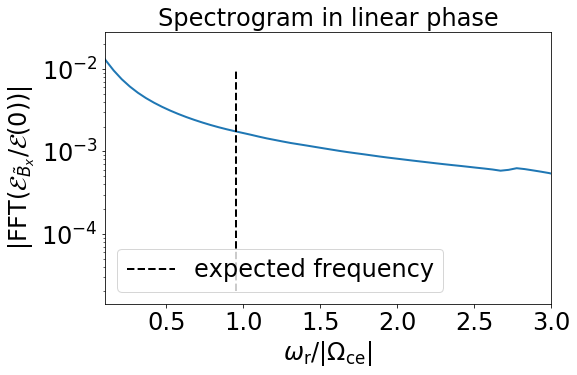

In [29]:
import matplotlib.pyplot as plt

f3 = plt.figure()
f3.set_figheight(5)
f3.set_figwidth(8)

fontsize = 24
#plt.rc('text', usetex = False)
#plt.rc('font', family = 'serif')
plt.rcParams.update({'font.size': fontsize})
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)

Ntend = 2400
spec = np.fft.fft(en_B[0:Ntend + 1])
spec = np.fft.fftshift(spec)
w = np.linspace(0, Ntend, Ntend + 1) - Ntend/2
w = 2*np.pi*w/(Ntend*dt)

plt.semilogy(w, np.abs(spec), linewidth = 2)
plt.semilogy(np.ones(10)*omega_r*2, np.linspace(2e-5, 1e-2, 10), 'k--', linewidth = 2, label = 'expected frequency')
#plt.xlim((0.1, 3))
#plt.ylim((1e-3, 1e-0))
plt.ylabel(r'$|\mathrm{FFT}(\mathcal{E}_{\tilde{B}_x} / \mathcal{E}(0))|$')
plt.xlabel(r'$\omega_{\mathrm{r}} / |\Omega_\mathrm{ce}|$')
plt.title('Spectrogram in linear phase', fontsize = fontsize)
plt.legend()

## 2. 4 Final distribution functions

Text(0.5,1,'Difference perpendicular')

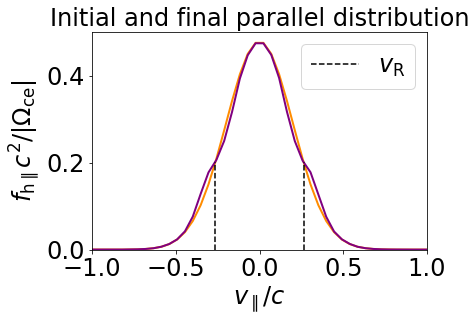

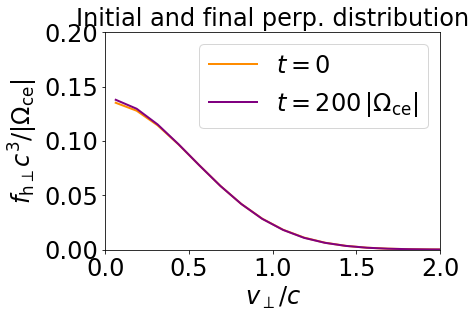

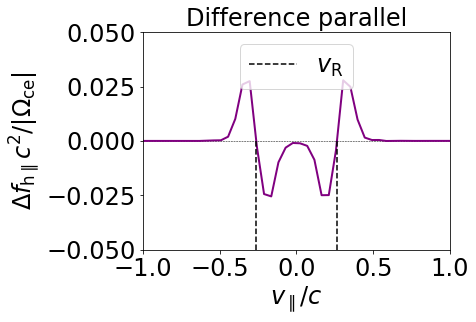

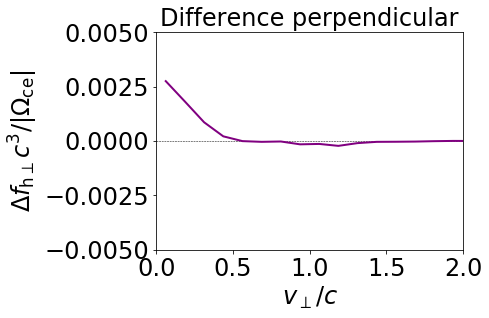

In [32]:
import matplotlib.pyplot as plt

fontsize = 24
plt.rcParams.update({'font.size': fontsize})
#plt.rc('text', usetex = True)
#plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)

Nbin_par = 128
Nbin_perp = 32

Lv_par = 6
Lv_perp = 4

dv_bin_par = Lv_par/Nbin_par
v_bin_par = np.linspace(-Lv_par/2, Lv_par/2, Nbin_par + 1)
v_bin_par = np.delete(v_bin_par, -1) + dv_bin_par/2
Vedges_par = np.linspace(-Lv_par/2, Lv_par/2, Nbin_par + 1)
binVol_par = dv_bin_par

dv_bin_perp = Lv_perp/Nbin_perp
v_bin_perp = np.linspace(0, Lv_perp, Nbin_perp + 1)
v_bin_perp = np.delete(v_bin_perp, -1) + dv_bin_perp/2
Vedges_perp = np.linspace(0, Lv_perp, Nbin_perp + 1)
binVol_perp = dv_bin_perp


# initial distribution
f_par_ini = fh0(0, 0, 0, v_bin_par, 0)*2*np.pi*wperp**2
f_perp_ini = fh0(0, v_bin_perp/np.sqrt(2), v_bin_perp/np.sqrt(2), 0, 0)*np.sqrt(2*np.pi)*wpar
# ...



# ... later distribution
Vbin_par = np.digitize(particles[:, 3], Vedges_par) - 1
Vbin_perp = np.digitize(np.sqrt(particles[:, 1]**2 + particles[:, 2]**2), Vedges_perp) - 1

f_par = np.bincount(Vbin_par, particles[:, 4], Nbin_par)/(Np*binVol_par*Lz) + control*f_par_ini
f_perp = np.bincount(Vbin_perp, particles[:, 4], Nbin_perp)/(Np*binVol_perp*Lz*v_bin_perp*2*np.pi) + control*f_perp_ini
# ...

# ... resonant velocity
omega = utils.solveDispersionHybrid(k, +1, c, wce, wpe, wpar, wperp, nuh, 0.5 + 0j, 1e-8)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)
vR = np.abs((omega_r + wce)/k)
# ...

f4 = plt.figure()
f4.set_figheight(4)
f4.set_figwidth(6)


plt.plot(v_bin_par, f_par_ini, linewidth = 2, color = 'darkorange')
plt.plot(v_bin_par, f_par, linewidth = 2, color = 'purple')
plt.plot(np.ones(10)*vR, np.linspace(0, fh0(0, 0, 0, vR, 0)*2*np.pi*wperp**2, 10), 'k--', label = '$v_\mathrm{R}$')
plt.plot(-np.ones(10)*vR, np.linspace(0, fh0(0, 0, 0, vR, 0)*2*np.pi*wperp**2, 10), 'k--')
plt.ylim((0, 0.5))
plt.xlim((-1, 1))
plt.xlabel('$v_\parallel/c$')
plt.ylabel('$f_{\mathrm{h}\parallel}c^2/|\Omega_\mathrm{ce}|$')
plt.title('Initial and final parallel distribution', fontsize = fontsize)
plt.legend()



f5 = plt.figure()
f5.set_figheight(4)
f5.set_figwidth(6)

plt.plot(v_bin_perp, f_perp_ini, label = '$t=0$', linewidth = 2, color = 'darkorange')
plt.plot(v_bin_perp, f_perp, label = '$t=200\,|\Omega_\mathrm{ce}|$', linewidth = 2, color = 'purple')
plt.xlabel('$v_\perp/c$')
plt.ylabel('$f_{\mathrm{h}\perp}c^3/|\Omega_\mathrm{ce}|$')
plt.ylim((0, 0.2))
plt.xlim((0, 2))
plt.title('Initial and final perp. distribution', fontsize = fontsize)
plt.legend()



f6 = plt.figure()
f6.set_figheight(4)
f6.set_figwidth(5.5)

plt.plot(-2, 0, linewidth = 2)
plt.plot(np.linspace(-1, 1, 10), np.zeros(10), 'k--', linewidth = 0.5)
plt.plot(v_bin_par, f_par - f_par_ini, linewidth = 2, color = 'purple')
plt.plot(np.ones(10)*vR, np.linspace(-0.05, 0, 10), 'k--', label = '$v_\mathrm{R}$')
plt.plot(-np.ones(10)*vR, np.linspace(-0.05, 0, 10), 'k--')
plt.legend(loc = 'upper center')

plt.xlim((-1, 1))
plt.ylim((-0.05, 0.05))
plt.xlabel('$v_\parallel/c$')
plt.ylabel('$\Delta f_{\mathrm{h}\parallel}c^2/|\Omega_\mathrm{ce}|$')
plt.title('Difference parallel', fontsize = fontsize)



f7 = plt.figure()
f7.set_figheight(4)
f7.set_figwidth(5.5)

plt.plot(-2, 0, linewidth = 2)
plt.plot(np.linspace(0, 2, 10), np.zeros(10), 'k--', linewidth = 0.5)
plt.plot(v_bin_perp, f_perp - f_perp_ini, linewidth = 2, color = 'purple')
plt.xlim((0, 2))
plt.ylim((-0.005, 0.005))
plt.xlabel('$v_\perp/c$')
plt.ylabel('$\Delta f_{\mathrm{h}\perp}c^3/|\Omega_\mathrm{ce}|$')
plt.title('Difference perpendicular', fontsize = fontsize)

## 2. 5 Compare energies

In [33]:
en_par_ini = Lz*nh*me/2*wpar**2
en_perp_ini = Lz*nh*me/2*2*wperp**2
en_ini = en_par_ini + en_perp_ini

delta_en_par = me/(2*Np)*np.dot(particles[:, 4], particles[:, 3]**2)
delta_en_perp = me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2)
delta_en = me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2)

print('Initial parallel energy: ' + str(en_par_ini))
print('Initial perp energy: ' + str(en_perp_ini))
print('Initial hot energy: ' + str(en_ini))
print('-----------')
print('Delta parallel energy: ' + str(delta_en_par))
print('Delta perp energy: ' + str(delta_en_perp))
print('Final hot energy: ' + str((delta_en_par + delta_en_perp) + en_ini))
print('-----------')
print('Delta hot energy: ' + str(delta_en_par + delta_en_perp))

Initial parallel energy: 0.015079644737231009
Initial perp energy: 0.21179361033440952
Initial hot energy: 0.22687325507164052
-----------
Delta parallel energy: 0.0008384688087224891
Delta perp energy: -0.001825463157902078
Final hot energy: 0.22588626072246093
-----------
Delta hot energy: -0.0009869943491795888


## 2. 6 Fourier spectrum in space and time

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import ConnectionPatch


# ... compute Bx on a space-time-grid and create w and k vectors
Nt = int(T/dt)
w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/T*w

ks = np.linspace(0, Nz, Nz + 1) - Nz/2
ks = 2*np.pi/Lz*ks

Bx = np.zeros((Nt + 1, Nz + 1))

for i in range(0, Nt + 1):
    if i%1000 == 0:
        print('time steps done : ' + str(i))
    Bx[i] = utils.evaluation(bx_save[i], bsp, zj, zj)
# ...

time steps done : 0
time steps done : 1000
time steps done : 2000
time steps done : 3000
time steps done : 4000
time steps done : 5000
time steps done : 6000


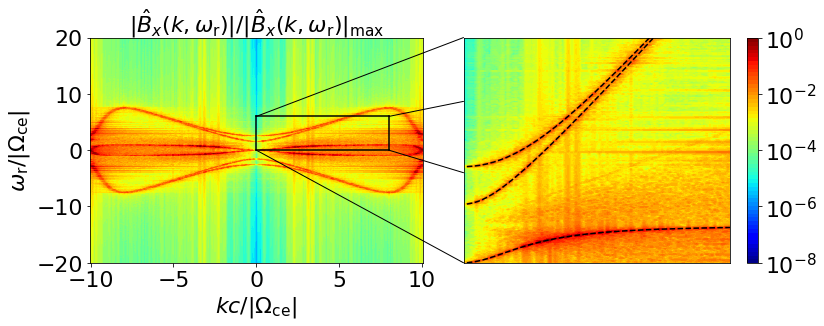

In [3]:
fontsize = 22
#plt.rc('text', usetex = True)
#plt.rc('font', family = 'serif')
plt.rcParams.update({'font.size': fontsize})
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)



Bxkw = np.fft.fft2(Bx)
K, W = np.meshgrid(ks, w)
Bkw = np.fft.fftshift(Bxkw)
Bkw_plot = np.abs(Bkw)


f8 = plt.figure()
f8.set_figheight(5)
f8.set_figwidth(12)

ax1 = plt.subplot(121)


ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.plot(np.linspace(0, 8, 10), np.zeros(10), 'k')
plt.plot(np.linspace(0, 8, 10), np.ones(10)*6, 'k')
plt.plot(np.zeros(10), np.linspace(0, 6, 10), 'k')
plt.plot(np.ones(10)*8, np.linspace(0, 6, 10), 'k')
plt.ylim((-20, 20))
plt.xlabel(r'$kc/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$\omega_\mathrm{r}/ |\Omega_\mathrm{ce}|$')
plt.title(r'$|\hat{B}_x(k,\omega_\mathrm{r})|/|\hat{B}_x(k,\omega_\mathrm{r})|_\mathrm{max}$', fontsize = fontsize)




ax2 = plt.subplot(122)


# ... analytical cold plasma dispersion relation
k1 = np.linspace(0.1, 8.0, 40)

w1_1 = np.zeros(40)
w1_2 = np.zeros(40)
w1_3 = np.zeros(40)

w1_1[0] = 0.0001 
w1_2[0] = 1.5001 
w1_3[0] = 2.5001


for i in range(0, 40):
    
    if i == 0:
        w1_1[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i], 1e-6, 100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i], 1e-6, 100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i], 1e-6, 100)[0]
    
    else:
        w1_1[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i-1], 1e-6, 100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i-1], 1e-6, 100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i-1], 1e-6, 100)[0]
# ...  

    

ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.xlim((0, 8))
plt.ylim((0, 6))
plt.colorbar(ticks = ticks)
plt.xticks([], [])
plt.yticks([], [])
plt.plot(k1, w1_1, 'k--')
plt.plot(k1, w1_2, 'k--')
plt.plot(k1, w1_3, 'k--')
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout()




con1 = ConnectionPatch(xyA = (0, 6), xyB = (0, 6), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 1)
con2 = ConnectionPatch(xyA = (0, 0), xyB = (0, 0), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 1)
con3 = ConnectionPatch(xyA = (0, 4.3), xyB = (8, 6), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 1)
con4 = ConnectionPatch(xyA = (0, 2.4), xyB = (8, 0), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 1)

ax2.add_artist(con1)
ax2.add_artist(con2)
ax2.add_artist(con3)
ax2.add_artist(con4)